Confirm that TripNet and TripModel generate sample results given the kernel

In [6]:
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sb
from scipy import stats

% matplotlib inline

In [7]:
trip_para = pd.read_pickle('/data/Gerstner_trip_para_df')
trip_para
# Reorder columns to match parameter of the model
trip_para = trip_para[['A2_+', 'A3_-', 'A2_-', 'A3_+', 'Tau_+', 'Tau_x', 'Tau_-', 'Tau_y']]
trip_para

A2_+     A3_-    A2_-    A3_+ Tau_+ Tau_x Tau_-  \
Visu_AlltoAll    Full    5e-10  0.00023   0.007  0.0062  16.8   101  33.7   
                 Min         0        0  0.0071  0.0065  16.8     1  33.7   
Visu_NearestSpk  Full  8.8e-11   0.0031  0.0066   0.053  16.8   714  33.7   
                 Min         0        0   0.008    0.05  16.8     1  33.7   
Hippo_AlltoAll   Full   0.0061   0.0014  0.0016  0.0067  16.8   946  33.7   
                 Min    0.0053        0  0.0035   0.008  16.8     1  33.7   
Hippo_NearestSpk Full   0.0046  7.5e-09   0.003  0.0091  16.8   575  33.7   
                 Min    0.0046        0   0.003  0.0091  16.8     1  33.7   

                      Tau_y  
Visu_AlltoAll    Full   125  
                 Min    114  
Visu_NearestSpk  Full    40  
                 Min     40  
Hippo_AlltoAll   Full    27  
                 Min     40  
Hippo_NearestSpk Full    47  
                 Min     48

1.0 1.0 1.0


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


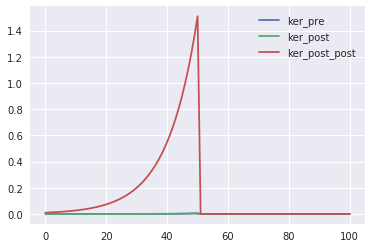

In [13]:
# Load Gerstner's kernel
# Visualize kernel
from modelval.kernel import KernelGen

para = trip_para.loc[('Hippo_AlltoAll', 'Min'), :]
ker_test = KernelGen()
ker_test.trip_model_ker(para, data_name='Hippocampus')

plt.plot(ker_test.kernel_pre * ker_test.kernel_scale[0], label='ker_pre')
plt.plot(ker_test.kernel_post * ker_test.kernel_scale[1], label='ker_post')
plt.plot(ker_test.kernel_post_post * ker_test.kernel_scale[2], label='ker_post_post')
plt.legend()
print(np.linalg.norm(ker_test.kernel_pre, ord=2), np.linalg.norm(ker_test.kernel_post, ord=2), np.linalg.norm(ker_test.kernel_post_post, ord=2))

In [15]:
# Load STDP data
vali_input_tt = np.load('/data/8ptl_vali_spk.npy')
vali_target_tt = np.load('/data/8ptl_vali_target.npy')
vali_ptl = np.load('/data/8ptl_vali_ptl.npy')

In [16]:
# Generate predcition with validation set from the augmented STDP data
STDP_vali_input = vali_input_tt[:int(vali_ptl[0]),:,:]
STDP_vali_target = vali_target_tt[:int(vali_ptl[0])]

In [17]:
# Generate prediction with Gerstner's model
loci_track_pre = []
loci_track_post = []
dt_track = []

for i in range(STDP_vali_input.shape[0]):
    loci_pre_STDP = np.where(STDP_vali_input[i,:,0] > 0)[0]
    loci_post_STDP = np.where(STDP_vali_input[i,:,1] > 0)[0]
    dt = np.mean(loci_post_STDP - loci_pre_STDP)
    dt_track.append(dt)
    
    loci_track_pre.append(loci_pre_STDP)
    loci_track_post.append(loci_post_STDP)
    
dt_final = np.hstack(dt_track)

w_AA_STDP, S_AA_STDP, dw_AA_STDP = TripModel.trip_AlltoAll(a, tau/reso_set, loci_track_pre, loci_track_post, ifSTDP=0, reso = reso_set, tt_len = 500, simu_step=1)
diff2 = dw_AA_STDP  - np.hstack(STDP_vali_target)
frac_var_tripmodel = 1 - np.mean(diff2 ** 2)/np.var(np.hstack(STDP_vali_target))
slope, intercept, r_value_tripmodel, p_value, std_err = stats.linregress(np.hstack(STDP_vali_target),np.squeeze(dw_AA_STDP))

NameError: name 'TripModel' is not defined

In [ ]:
# Prediction with TripNet using TripModel parameter
TripNet_pred = TripNet.target_gen(data_train_pre=STDP_vali_input[:,:,0], data_train_post=STDP_vali_input[:,:,1] , kernel_pre_post=ker_pre_post_hp, kernel_post_pre=ker_post_pre_hp, kernel_post_post=ker_post_post_hp, len_ker=len_ker)
diff3 = np.hstack(TripNet_pred[0]) - np.hstack(STDP_vali_target)
frac_var_tripnet = 1 - np.mean(diff3 ** 2)/np.var(np.hstack(STDP_vali_target))
slope, intercept, r_value_tripnet, p_value, std_err = stats.linregress(np.hstack(STDP_vali_target),np.hstack(TripNet_pred[0]))
y_fit = np.hstack(STDP_vali_target) * slope + intercept

In [ ]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(np.hstack(TripNet_pred[0]), dw_AA_STDP,'.')
plt.plot(np.linspace(-0.2,0.3,10), np.linspace(-0.2,0.3,10), 'r')
plt.xlabel('TripNet_pred')
plt.ylabel('TripModel_pred')
plt.subplot(1,2,2)
plt.plot(dt_final * reso_set, dw_AA_STDP, '.', label='TripModel')
plt.plot(dt_final * reso_set, np.hstack(TripNet_pred[0]), 'r.', label='TripNet')
plt.xlabel('$\Delta {t}$(ms)')
plt.ylabel('$\Delta {w}$')
plt.legend(loc='upper right')